In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm

In [2]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 100;

In [3]:
df = pd.read_csv('SPY.csv')

In [4]:
# Volatility is computed by obtaining variance between current close and prices of past 10 days
Volatility = []

# MA is the 10 day SMA
MA = []

# Return is the single-day percentage return
Return = []
ma_sum = 0;

# Warming up data for moving average and volatility calculations
for i in range (0, 10):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += df['Close'][i];

# Filling in data for return, moving average, and volatility
for ind in df.index: 
    if ind >= 10:
        tail_close = df['Close'][ind-10];
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/10;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for i in range (0,10):
            curr_vol = abs(ma_curr - df['Close'][ind-i]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/10);

        

In [5]:
# Adding columns to dataframe
df['Volatility'] = Volatility;
df['MA'] = MA;
df['Return'] = Return;

In [6]:
# Dataframe readjustment
df = df.drop(range(0,10));
df.index = range(0, 6828);
df.head();

In [7]:
# Creating testing and training dataset
# 5828 datapoints in training, 1000 datapoints in test
test = pd.DataFrame(df, index = range(5828, 6828))
test.index = range(0,1000)
training = df.drop(range(5828, 6828))

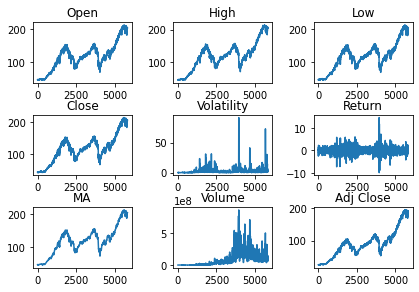

In [8]:
fig, a =  plt.subplots(3,3)
x = np.arange(1,5)
fig.tight_layout()
a[0][0].plot(range(0,5828), training.iloc[:,1])
a[0][0].set_title('Open')
a[0][1].plot(range(0,5828), training.iloc[:,2])
a[0][1].set_title('High')
a[0][2].plot(range(0,5828), training.iloc[:,3])
a[0][2].set_title('Low')
a[1][0].plot(range(0,5828), training.iloc[:,4])
a[1][0].set_title('Close')
a[1][1].plot(range(0,5828), training.iloc[:,7])
a[1][1].set_title('Volatility')
a[1][2].plot(range(0,5828), training.iloc[:,9])
a[1][2].set_title('Return')
a[2][0].plot(range(0,5828), training.iloc[:,8])
a[2][0].set_title('MA')
a[2][1].plot(range(0,5828), training.iloc[:,6])
a[2][1].set_title('Volume')
a[2][2].plot(range(0,5828), training.iloc[:,5])
a[2][2].set_title('Adj Close')
plt.show()


In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility,MA,Return
0,1993-02-12,44.87500,44.87500,44.59375,44.59375,26.692072,42500,0.064023,44.725000,-0.764951
1,1993-02-16,44.46875,44.46875,43.40625,43.46875,26.018700,374800,0.193174,44.646875,-2.522775
2,1993-02-17,43.46875,43.53125,43.28125,43.43750,25.999992,210900,0.322031,44.556250,-0.071891
3,1993-02-18,43.93750,43.93750,42.81250,43.40625,25.981276,378100,0.427939,44.415625,-0.071942
4,1993-02-19,43.40625,43.56250,43.34375,43.56250,26.074812,34900,0.445908,44.271875,0.359971


In [10]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations);
vol = training.iloc[:,7];
ret = training.iloc[:,9];
obs = [];
for i in range(0, len(vol)):
    arr = [];
    arr.append(vol[i]);
    arr.append(ret[i]);
    obs.append(arr);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

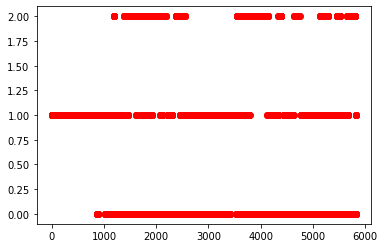

In [11]:
plt.plot(predictions, 'ro');

In [12]:
# Regime Classification
regime_vol = [];
regime_ret = [];
regime_count = [];
return_map = {};

for i in range(0, hidden_states):
    regime_vol.append(0);
    regime_ret.append(0);
    regime_count.append(0);

for i in range(0, len(predictions)):
    regime_count[predictions[i]] += 1;
    regime_vol[predictions[i]] += training.iloc[i, 7];
    regime_ret[predictions[i]] += training.iloc[i, 9];
    
    if not predictions[i] in return_map:
        return_map[predictions[i]] = [];
    return_map[predictions[i]].append(training.iloc[i,9]);
    
for i in range(0, hidden_states):
    regime_vol[i] = regime_vol[i] / regime_count[i];
    regime_ret[i] = regime_ret[i] / regime_count[i];

In [13]:
max_occurrence = np.argmax(regime_count)
for i in range(0, hidden_states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol[i]));
    print("Avg Return: {0}".format(regime_ret[i]));
    print("Occurrence: {0}\n".format(regime_count[i]));

Regime 0
Avg Vol: 2.7231757413088213
Avg Return: 0.022857999059397862
Occurrence: 2595

Regime 1
Avg Vol: 0.4906469407424971
Avg Return: 0.06254754628746124
Occurrence: 2592

Regime 2
Avg Vol: 11.572665346540132
Avg Return: -0.044664856910509886
Occurrence: 641



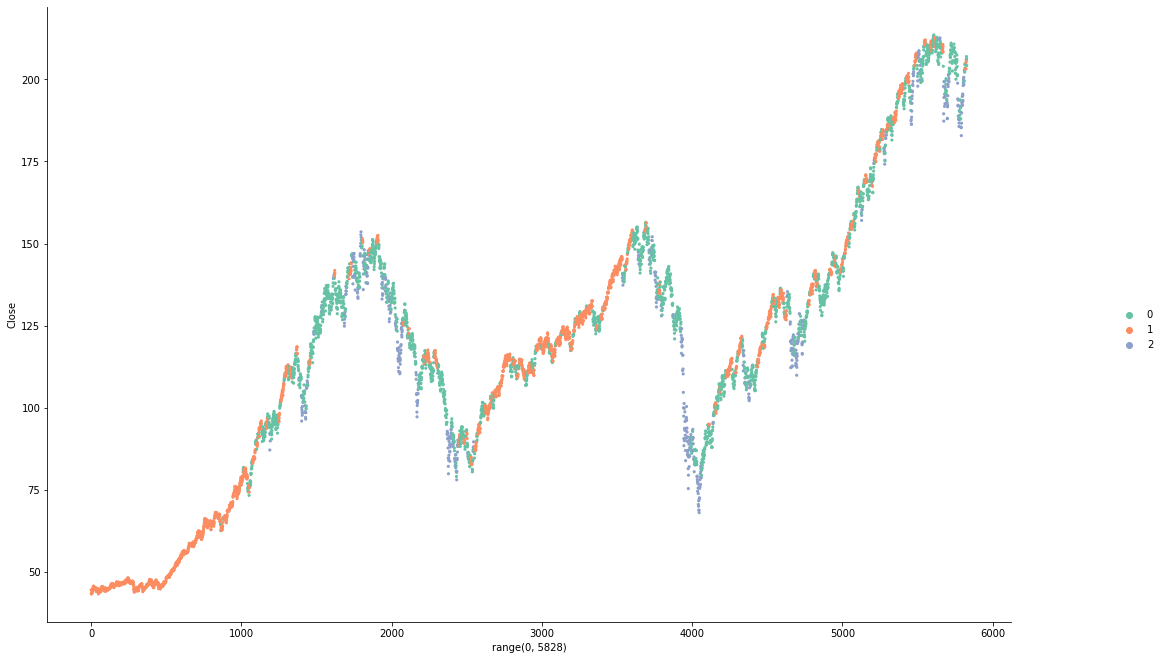

In [14]:
plot = sns.relplot(x=range(0,5828), y="Close", data=training, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [15]:
returns = pd.DataFrame(data = return_map[max_occurrence])
for i in range(0, hidden_states):
    if(i is not max_occurrence):
        returns[i] = pd.Series(return_map[i]);

#sns.pairplot(data = returns, height=3);


In [16]:
distribution = model.get_stationary_distribution();
for i in range(0, hidden_states):
    print("Regime {0}: {1}".format(i, distribution[i]));


Regime 0: 0.44484557925572704
Regime 1: 0.4409884544829987
Regime 2: 0.11416596626127422


In [17]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: -17120.02966558283


[Text(0, 0, '1'), Text(0, 0, '0'), Text(0, 0, '2')]

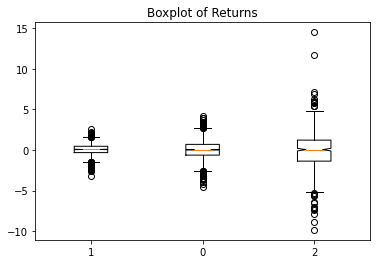

In [24]:
# Boxplot of returns
fig, ax = plt.subplots()
ax.set_title("Boxplot of Returns")
ax.boxplot(return_map.values(), notch=True, vert = True, autorange = True)
ax.set_xticklabels(return_map.keys())